# A neural N-mixture model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Simulate data at `nsite` sites, with `nrep` repeat surveys. Here it's assumed that there is one continuous site-level covariate $x$ that has some nonlinear relationship with the expected number of individuals at a site.

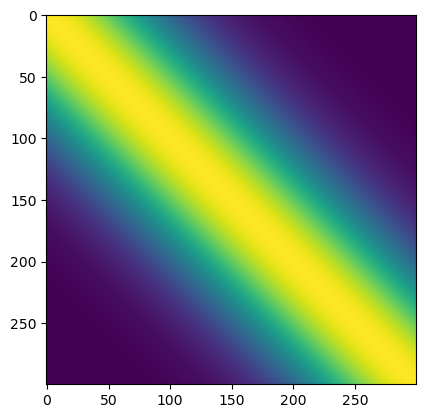

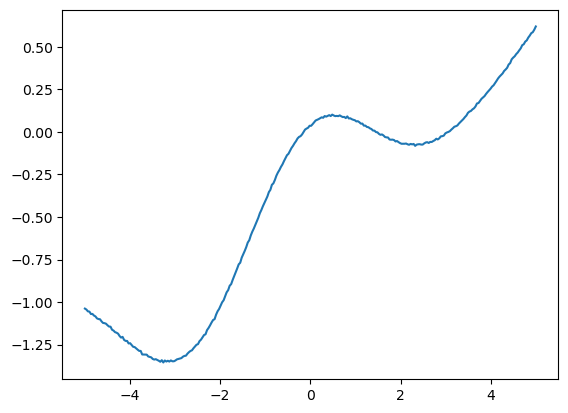

In [2]:
nsite = 300
nrep = 5
x = np.linspace(-5, 5, nsite, dtype=np.float32).reshape(-1,1)

# Draw f(x) from a Gaussian process
def kernel(x, theta):
    m, n = np.meshgrid(x, x)
    sqdist = abs(m-n)**2
    return np.exp(- theta * sqdist)

K = kernel(x, theta=.1)
L = np.linalg.cholesky(K + 1e-5* np.eye(nsite))
f_prior = np.dot(L, np.random.normal(size=(nsite, 1)))

# plot kernel
plt.imshow(K)
plt.show()

# plot function
plt.plot(x, f_prior)
plt.show()

## Generate true abundance values

In [3]:
offset = 3
lam = np.exp(f_prior + offset)
n = np.random.poisson(lam)

Text(0, 0.5, 'True abundance')

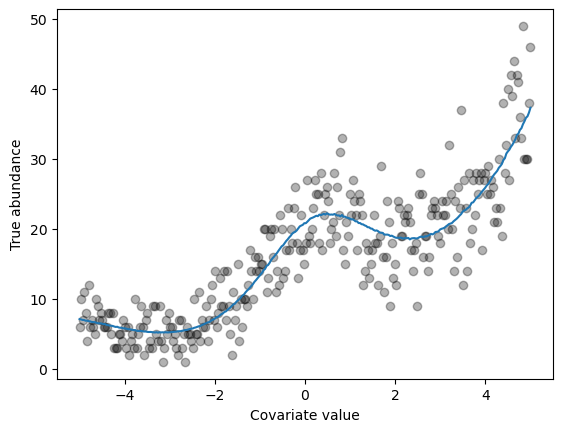

In [4]:
plt.scatter(x, n, c='k', alpha=.3)
plt.plot(x, lam)
plt.xlabel('Covariate value')
plt.ylabel('True abundance')

## Generate count observations

For simplicity, assume that the probability of detection is constant across all sites and independent of $x$.

In [5]:
pr_detection = np.array([.4], dtype=np.float32)
y = np.random.binomial(n=n, p=pr_detection, size=(nsite, nrep)).astype(np.float32)

The observed abundance is some fraction of the true abundance:

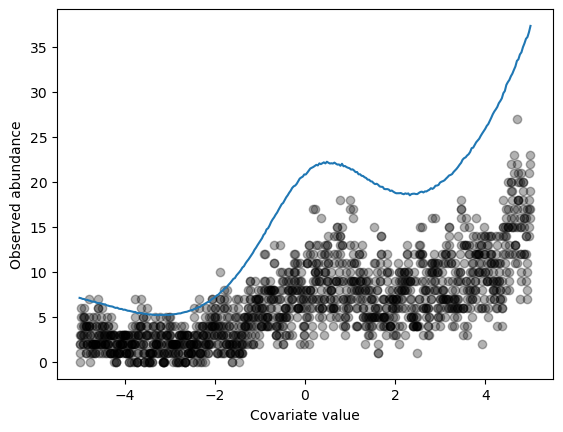

In [6]:
plt.plot(x, lam)
for i in range(nrep):
    plt.scatter(x, y[:, i], c='k', alpha=.3)    
plt.xlabel('Covariate value')
plt.ylabel('Observed abundance')
plt.show()

## Define a model

In [7]:
class NMixture(nn.Module):
    """ Neural N-mixture model 
    
    This is a neural network that ingests x and outputs:
    - lam(bda): expected abundance
    - p: detection probability
    """
    def __init__(self):
        super(NMixture, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = self.fc3(x)
        lam = torch.exp(output[:, [0]])
        p = torch.sigmoid(output[:, [1]])
        return lam, p

In [8]:
net = NMixture()
net.to(device)
running_loss = list()

## Train the model

To train the model, create a Pytorch DataLoader, set up an optimizer, and then iterate over the dataset `n_epoch` times, training via stochastic minibatch gradient descent.

In [9]:
class FakeDataset(Dataset):
    """ A Datset class for simulated data"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return x[idx, :], y[idx, :]

# create a DataLoader to load training examples
dataloader = DataLoader(FakeDataset(x, y), 
                        batch_size=256,
                        shuffle=True, 
                        num_workers=2)

In [10]:
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)

# generate a set of n values over which to enumerate in the likelihood
n_max = int(np.max(y) * 5)
n_vals = torch.from_numpy(np.arange(start=0, stop=n_max, dtype=np.float32)).to(device)

In [11]:
n_grid = n_vals.unsqueeze(0).unsqueeze(-1)

In [12]:
n_epoch = 500

In [13]:
for i in tqdm(range(n_epoch)):
    for i_batch, xy in enumerate(dataloader):
        x_i, y_i = xy
        x_i = x_i.to(device)
        y_i = y_i.to(device)

        optimizer.zero_grad()
        lam_i, p_i = net(x_i)

        # compute disribution of unobserved true abundance (n)
        dist_n = torch.distributions.poisson.Poisson(lam_i)
        lp_n = dist_n.log_prob(n_vals)
        
        # compute distribution of observations (y)
        p_grid = p_i.unsqueeze(-1).expand(-1, 1, nrep) # (batch_size, n_max, nrep)
        dist_y = torch.distributions.binomial.Binomial(n_grid, probs=p_grid, validate_args=False)

        # sum over repeat surveys to get the probability of y (batch_size, n_max)
        lp_y = dist_y.log_prob(y_i.unsqueeze(1).repeat(1, n_max, 1)).sum(dim=2) # sum over repeat surveys

        # multiply [y | N=n] * [N = n], yielding shape (batch_size, n_max), then sum over n
        log_prob = torch.logsumexp(lp_n + lp_y, 1)

        loss = -torch.mean(log_prob)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().data.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:59<00:00,  8.41it/s]


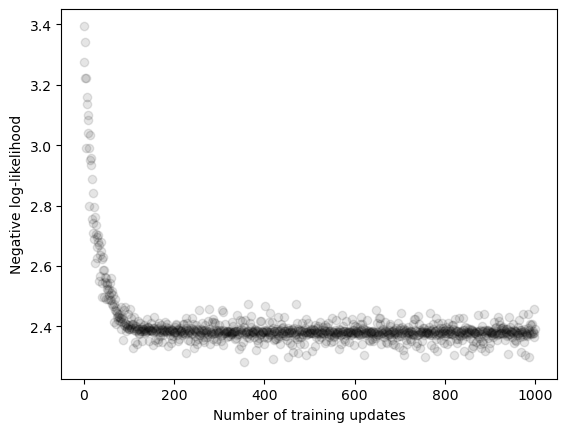

In [14]:
plt.scatter(np.arange(len(running_loss)), np.log(running_loss), alpha=.1, c='k')
plt.xlabel("Number of training updates")
plt.ylabel("Negative log-likelihood")
plt.show()

### What did the model estimate about the relationship between $x$ and abundance?

In [15]:
lam_hat, p_hat = net(torch.from_numpy(x).to(device))
lam_hat = lam_hat.cpu().detach().numpy()

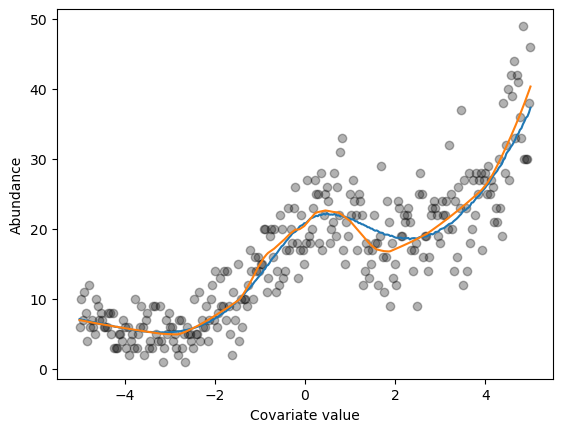

In [16]:
plt.scatter(x, n, c='k', alpha=.3)
plt.plot(x, lam)
plt.plot(x, lam_hat)
plt.xlabel('Covariate value')
plt.ylabel('Abundance')
plt.show()

### What did the model estimate about the relationship between $x$ and detection?

Recall that the detection probability was fixed, and not a function of $x$ in the generative simulation.

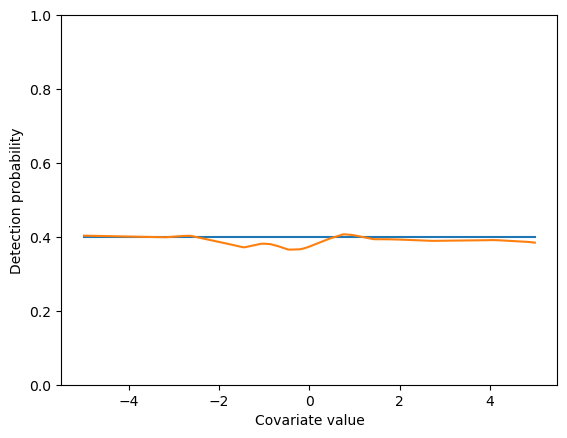

In [17]:
plt.plot(x, pr_detection * np.ones_like(x))
plt.plot(x, p_hat.cpu().detach().numpy())
plt.ylim(0, 1)
plt.xlabel('Covariate value')
plt.ylabel('Detection probability')
plt.show()